In [1]:
import setGPU
import torch
import torch_geometric
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data, DataLoader

setGPU: Setting GPU to: 1


In [2]:
import sys
sys.path += ["../test"]

In [3]:
import train_end2end
import graph_data
%matplotlib inline

torch 1.4.0
torch_geometric 1.4.3


In [4]:
device = torch.device("cuda")

In [79]:
weights = torch.load("/storage/user/jpata/particleflow/data/PFNet7_cand__npar_279055__cfg_2450dba99c__user_jpata__ntrain_100__lr_0.001__1585163522/epoch_

In [106]:
model = train_end2end.PFNet7(23, 256, 14)
model.load_state_dict(weights)
model = model.to(device)

RuntimeError: Error(s) in loading state_dict for PFNet7:
	Missing key(s) in state_dict: "conv1.lin.weight", "conv1.lin.bias", "nn1.12.weight", "nn1.12.bias". 
	Unexpected key(s) in state_dict: "inp.0.weight", "inp.0.bias", "inp.3.weight", "inp.3.bias", "inp.6.weight", "inp.6.bias", "inp.9.weight", "inp.9.bias", "edgenet.0.weight", "edgenet.0.bias", "edgenet.3.weight", "edgenet.3.bias", "edgenet.6.weight", "edgenet.6.bias", "edgenet.9.weight", "edgenet.9.bias", "conv2.weight", "conv2.att", "conv2.bias", "nn2.0.weight", "nn2.0.bias", "nn2.3.weight", "nn2.3.bias", "nn2.6.weight", "nn2.6.bias", "nn2.9.weight", "nn2.9.bias", "conv1.weight", "conv1.att", "conv1.bias". 
	size mismatch for nn1.0.weight: copying a param with shape torch.Size([128, 151]) from checkpoint, the shape in current model is torch.Size([256, 279]).
	size mismatch for nn1.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for nn1.3.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for nn1.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for nn1.6.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for nn1.6.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for nn1.9.weight: copying a param with shape torch.Size([11, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for nn1.9.bias: copying a param with shape torch.Size([11]) from checkpoint, the shape in current model is torch.Size([256]).

In [81]:
model

PFNet6(
  (inp): Sequential(
    (0): Linear(in_features=23, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=128, out_features=128, bias=True)
  )
  (conv1): GATConv(128, 128, heads=4)
  (edgenet): Sequential(
    (0): Linear(in_features=257, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): LeakyReLU(negative_slope=0.0

In [82]:
# for real validation, use QCD
#p = "/storage/user/jpata/particleflow/data/QCD_run3"
# just to see, use TTbar (note it was trained on same events)
p = "/storage/user/jpata/particleflow/data/TTbar_gen_phase1/"
full_dataset = graph_data.PFGraphDataset(root=p)
test_dataset = torch.utils.data.Subset(full_dataset, np.arange(start=100, stop=200))

In [83]:
loader = DataLoader(test_dataset, batch_size=1)

In [84]:
pred_ids = []
true_ids = []
pred_momenta = []
true_momenta = []

for i, d in enumerate(loader):
    d = d.to(device)
    train_end2end.data_prep(d, device=device)
    edges, cand_id_onehot, cand_momentum = model(d)
    _, pred_id = torch.max(cand_id_onehot, -1)
    pred_ids += [pred_id.detach().cpu().numpy()]
    true_ids += [d.y_candidates_id.detach().cpu().numpy()]
    pred_momenta += [cand_momentum.detach().cpu().numpy()]
    true_momenta += [d.ycand.detach().cpu().numpy()]
    if i%100 == 0:
        print(i, len(loader))

0 100


In [85]:
n_preds = []
n_trues = []
for i in range(len(pred_ids)):
    n_true = np.sum(true_ids[i]!=0)
    n_pred = np.sum(pred_ids[i]!=0)
    n_preds += [n_pred]
    n_trues += [n_true]

In [86]:
%matplotlib inline

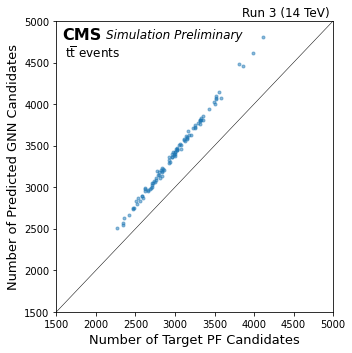

In [87]:
plt.figure(figsize=(5, 5))
ax = plt.axes()
plt.plot([1500,5000],[1500,5000], color="black", lw=0.5)
plt.scatter(n_trues, n_preds, marker=".", alpha=0.5)
plt.xlim(1500,5000)
plt.ylim(1500,5000)
plt.xlabel("Number of Target PF Candidates",fontsize=13)
plt.ylabel("Number of Predicted GNN Candidates",fontsize=13)
#plt.title("QCD Run3")

plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
#plt.savefig("num_pred.pdf")

In [88]:
cms = []
for i in range(len(pred_ids)):
    cm = sklearn.metrics.confusion_matrix(
        true_ids[i],
        pred_ids[i], labels=range(len(train_end2end.class_labels))
    )
    cms += [cm]
cm = sum(cms)
cm = cm / 1000.0
cm = np.round(cm, 1)#.astype(np.int)

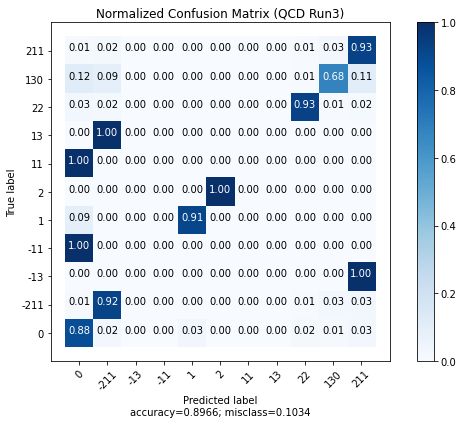

In [89]:
train_end2end.plot_confusion_matrix(cm, [int(x) for x in train_end2end.class_labels], normalize=True)
#plt.xlim(-0.5, 9.5)
#plt.ylim(-0.5, 9.5)
plt.title("Normalized Confusion Matrix (QCD Run3)")
#plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
#plt.tight_layout()
plt.savefig("cm.pdf")

In [96]:
pm = np.concatenate(pred_momenta)
tm = np.concatenate(true_momenta)
ti = np.concatenate(true_ids)
pi = np.concatenate(pred_ids)


pm[:, 0] = np.power(10, pm[:, 0])
tm[:, 0] = np.power(10, tm[:, 0])

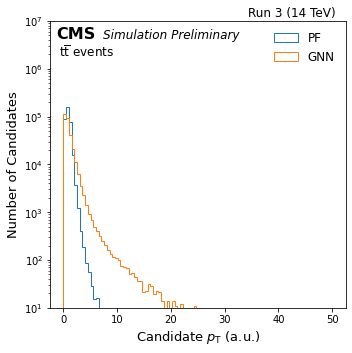

In [97]:
plt.figure(figsize=(5, 5))

ax = plt.axes()
bins = np.linspace(0, 50, 100)
h0 = plt.hist(pm[pi!=0, 0], bins=bins, histtype="step", lw=1, label="PF");
h1 = plt.hist(tm[ti!=0, 0], bins=bins, histtype="step", lw=1, label="GNN");
plt.yscale("log")
plt.legend(frameon=False)
plt.ylim(10, 1e7)

plt.xlabel("Candidate $p_{\mathrm{T}}$ (a.u.)",fontsize=13)
plt.ylabel("Number of Candidates",fontsize=13)
#plt.title("QCD Run 3")

plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("pt_hist.pdf")

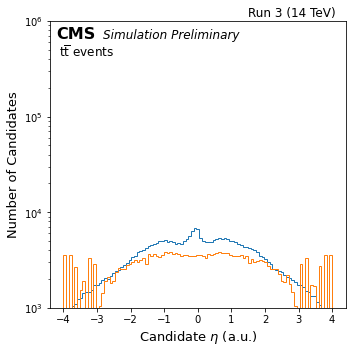

In [98]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

bins = np.linspace(-4, 4, 100)
plt.hist(pm[pi!=0, 1], bins=bins, histtype="step", lw=1);
plt.hist(tm[ti!=0, 1], bins=bins, histtype="step", lw=1);
plt.yscale("log")

plt.ylim(1000, 1e6)
plt.xlabel("Candidate $\eta$ (a.u.)",fontsize=13)
plt.ylabel("Number of Candidates",fontsize=13)
#plt.title("QCD Run 3")
plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("eta_hist.pdf")

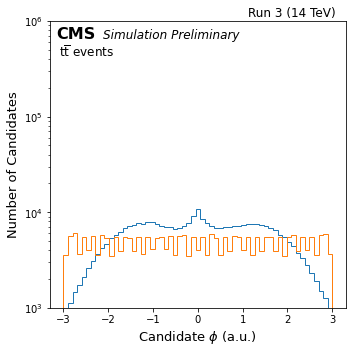

In [99]:
plt.figure(figsize=(5, 5))

ax = plt.axes()
bins = np.linspace(-3, 3, 60)
plt.hist(pm[pi!=0, 2], bins=bins, histtype="step", lw=1);
plt.hist(tm[ti!=0, 2], bins=bins, histtype="step", lw=1);
plt.yscale("log")
plt.ylim(1000, 1e6)

plt.xlabel("Candidate $\phi$ (a.u.)",fontsize=13)
plt.ylabel("Number of Candidates",fontsize=13)
#plt.title("QCD Run 3")

plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("phi_hist.pdf")

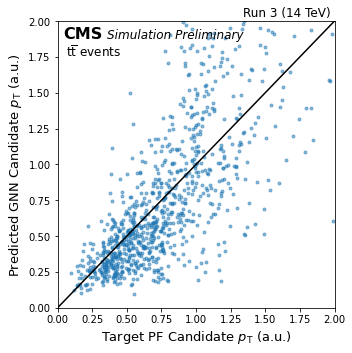

In [100]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

subidx = np.where((pi!=0)&(ti!=0))[0]
rp = np.random.permutation(range(len(subidx)))[:1000]

plt.scatter(pm[subidx[rp], 0], tm[subidx[rp], 0], marker=".", alpha=0.5)
plt.xlim(0,2)
plt.ylim(0,2)
plt.plot([0,2],[0,2], color="black")

plt.xlabel("Target PF Candidate $p_{\mathrm{T}}$ (a.u.)",fontsize=13)
plt.ylabel("Predicted GNN Candidate $p_{\mathrm{T}}$ (a.u.)", fontsize=13)
#plt.title("QCD Run 3, 1000 candidates")

plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("pt_corr.pdf")

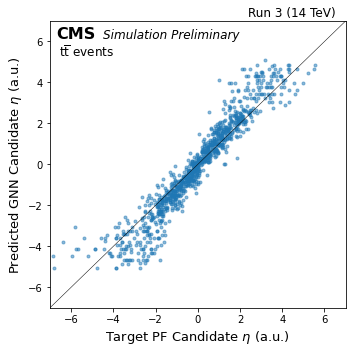

In [101]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

plt.plot([-7, 7], [-7, 7], color="black", lw=0.5)
plt.scatter(pm[subidx[rp], 1], tm[subidx[rp], 1], marker=".", alpha=0.5)
plt.xlim(-7, 7)
plt.ylim(-7, 7)

plt.xlabel("Target PF Candidate $\eta$ (a.u.)",fontsize=13)
plt.ylabel("Predicted GNN Candidate $\eta$ (a.u.)",fontsize=13)
#plt.title("QCD Run 3, 1000 candidates")
plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("eta_corr.pdf")

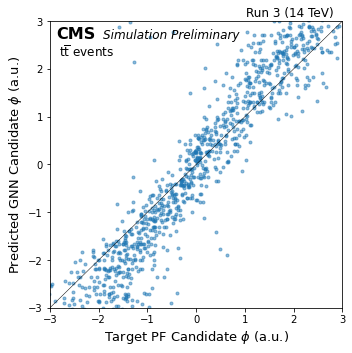

In [102]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

plt.plot([-5, 5], [-5, 5], color="black", lw=0.5)
plt.scatter(pm[subidx[rp], 2], tm[subidx[rp], 2], marker=".", alpha=0.5)
plt.xlim(-3,3)
plt.ylim(-3,3)


plt.xlabel("Target PF Candidate $\phi$ (a.u.)",fontsize=13)
plt.ylabel("Predicted GNN Candidate $\phi$ (a.u.)",fontsize=13)
#plt.title("QCD Run3, 1000 candidates")

plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("phi_corr.pdf")

10114it [00:02, 3469.74it/s]                         
  0%|          | 0/5944 [00:00<?, ?it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

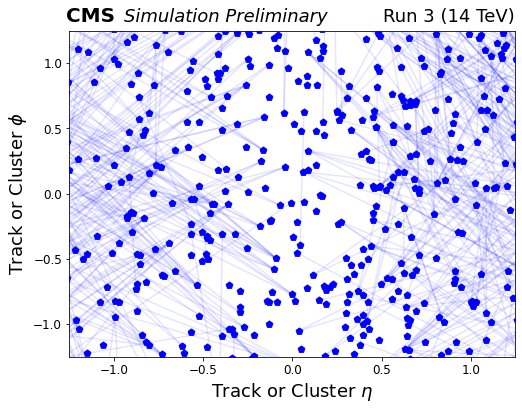

<Figure size 576x432 with 0 Axes>

In [105]:
import pandas as pd
import tqdm

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

d = full_dataset.get(1)
d.batch = torch.zeros((len(d.x)), dtype=torch.long)
d = d.to(device=device)
train_end2end.data_prep(d, device=device)
edges, cand_id_onehot, cand_momentum = model(d)
output = edges.detach().cpu().numpy()
d = full_dataset.get(1)
x_data = d.x.detach().cpu().numpy()
mask = ((x_data[:,4]==0) & (x_data[:,5]==0) & (x_data[:,6]==0) & (x_data[:,7]==0))
good_index = np.zeros((x_data.shape[0],1,2),dtype=int)
good_x = x_data[:,2:4].copy()                                                                            
good_x[~mask] = x_data[~mask,2:4].copy()
df = pd.DataFrame(good_x, columns=['eta','phi'])
df['isTrack'] = ~mask
row, col = d.edge_index.cpu().detach().numpy()
y_truth = d.ycand.cpu().detach().numpy()

min_phi = -1.25
max_phi = 1.25
min_eta = -1.25
max_eta = 1.25
extra = 1.0
x = 'eta'
y = 'phi'
for plot_type in [['input'],['truth'],['output']]: 
    k = 0
    plt.figure(figsize=(8, 6))                        
    for i, j in tqdm.tqdm(zip(row, col),total=len(y_truth)):
        x1 = df[x][i]
        x2 = df[x][j]
        y1 = df[y][i]
        y2 = df[y][j]
        if (x1 < min_eta-extra or x1 > max_eta+extra) or (x2 < min_eta-extra or x2 > max_eta+extra): continue
        if (y1 < min_phi-extra or y1 > max_phi+extra) or (y2 < min_phi-extra or y2 > max_phi+extra): continue
        if 'input' in plot_type:
            seg_args = dict(c='b',alpha=0.1,zorder=1)
            plt.plot([df[x][i], df[x][j]],
                 [df[y][i], df[y][j]], '-', **seg_args)
        if 'truth' in plot_type and y_truth[k]:
            seg_args = dict(c='r',alpha=0.8,zorder=2)
            plt.plot([df[x][i], df[x][j]],
                 [df[y][i], df[y][j]], '-', **seg_args)
        if 'output' in plot_type:
            seg_args = dict(c='g',alpha=output[k].item(),zorder=3)
            plt.plot([df[x][i], df[x][j]],
                 [df[y][i], df[y][j]], '-', **seg_args)
        k+=1
    cut_mask = (df[x] > min_eta-extra) & (df[x] < max_eta+extra) & (df[y] > min_phi-extra) & (df[y] < max_phi+extra)
    cluster_mask = cut_mask & ~df['isTrack']
    track_mask = cut_mask & df['isTrack']
    plt.scatter(df[x][cluster_mask], df[y][cluster_mask],c='g',marker='o',s=50,zorder=4,alpha=1)
    plt.scatter(df[x][track_mask], df[y][track_mask],c='b',marker='p',s=50,zorder=5,alpha=1)
    plt.xlabel("Track or Cluster $\eta$",fontsize=18)
    plt.ylabel("Track or Cluster $\phi$",fontsize=18)
    plt.xlim(min_eta, max_eta)
    plt.ylim(min_phi, max_phi)
    plt.figtext(0.12, 0.90,'CMS',fontweight='bold', wrap=True, horizontalalignment='left', fontsize=20)
    plt.figtext(0.22, 0.90,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left', fontsize=18)
    plt.figtext(0.67, 0.90,'Run 3 (14 TeV)',  wrap=True, horizontalalignment='left', fontsize=18)
    plt.savefig('graph_%s_%s_%s.pdf'%(x,y,'_'.join(plot_type)))